In [1]:
import PyPDF2

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        # Utilisez PdfReader à la place de PdfFileReader
        pdf_reader = PyPDF2.PdfReader(file)
        text = ''
        # Utilisez len(reader.pages) au lieu de reader.numPages
        for page_num in range(len(pdf_reader.pages)):
            if page_num % 100 == 0:
                print(f'Page {page_num}')
            page = pdf_reader.pages[page_num]
            text += page.extract_text()
    return text

In [2]:
code_educ = extract_text_from_pdf('code-de-léducation.pdf')

Page 0
Page 100
Page 200
Page 300
Page 400
Page 500
Page 600
Page 700
Page 800
Page 900
Page 1000
Page 1100
Page 1200
Page 1300
Page 1400
Page 1500


In [3]:
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess

In [4]:
def text_to_corpus(text):
    sentences = sent_tokenize(text)
    corpus_token = [
    [word for word in simple_preprocess(sentence, deacc = True)] 
    for sentence in sentences
]
    return corpus_token

In [5]:
corpus_code = text_to_corpus(code_educ)

In [6]:
from gensim.models import Word2Vec

In [7]:
#création du modèle
model5 = Word2Vec(window=5)
model5.build_vocab(corpus_code)

In [8]:
model5.train(corpus_code, total_examples=model5.corpus_count, epochs= 5)

(1828018, 2688335)

In [ ]:
model5.wv.most_similar('loi')

[('ordonnance', 0.8820413947105408),
 ('juillet', 0.8819384574890137),
 ('resultant', 0.8643450140953064),
 ('aout', 0.8611114025115967),
 ('relative', 0.846413791179657),
 ('octobre', 0.8392878770828247),
 ('septembre', 0.8378618955612183),
 ('novembre', 0.8367295861244202),
 ('er', 0.8328056335449219),
 ('decembre', 0.8045275211334229)]

In [12]:
from graphe_linguistique_FUNCTION import créer_reseau_récursif, dessin_graphe

In [13]:
import networkx as nx

In [14]:
G = nx.Graph()

In [17]:
créer_reseau_récursif( model5, 'loi' , G, 0)

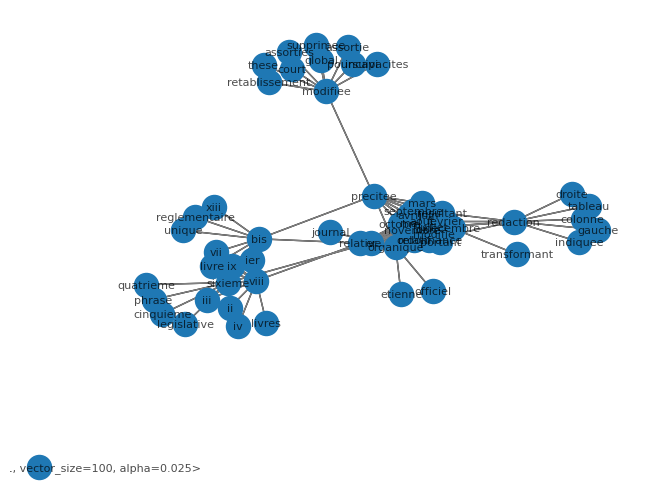

In [18]:
dessin_graphe(G)

**Le notebook suivant implémente le modèle linguistique présenté dans l'article : _Construction d’espaces sémantiques 
à l’aide de dictionnaires de synonymes_ par Sabine Ploux et Bernard Victorri.** 

On va déduire du modèle un graphe qui va nous être utile pour la suite. 

In [65]:
similar_words = model5.wv.most_similar('loi')

In [66]:
print(similar_words)

[('ordonnance', 0.8820413947105408), ('juillet', 0.8819384574890137), ('resultant', 0.8643450140953064), ('aout', 0.8611114025115967), ('relative', 0.846413791179657), ('octobre', 0.8392878770828247), ('septembre', 0.8378618955612183), ('novembre', 0.8367295861244202), ('er', 0.8328056335449219), ('decembre', 0.8045275211334229)]


In [67]:
model5.wv.most_similar('decembre')


[('avril', 0.9635292291641235),
 ('fevrier', 0.958539605140686),
 ('mai', 0.9324666857719421),
 ('novembre', 0.9296686053276062),
 ('septembre', 0.9274869561195374),
 ('octobre', 0.9252391457557678),
 ('juillet', 0.9165114164352417),
 ('portant', 0.9152854084968567),
 ('aout', 0.9124245047569275),
 ('juin', 0.9089904427528381)]

**Attention** : Un mot peut être dans les 10 plus similaires d'un autre sans que la réciproque soit vraie. 

Le graphe sera constitué de la façon suivante : chaque mot sera un noeud. Chaque noeud sera relié aux 10 autres noeuds associés aux 10 mots les plus similaires au mot considéré. 

In [109]:
import networkx as nx
# Dessiner le graphe : facultatif, nécessite matplotlib
import matplotlib.pyplot as plt

In [110]:
# Créer un graphe non-dirigé avec NetworkX
Gr = nx.Graph()

In [111]:
# def créer_noeud_mot(model, word, G, topn=10):
#     for similar_word, similarity_score in model.wv.most_similar(word, topn=topn):
#         G.add_node(similar_word)
#         G.add_edge(word, similar_word, weight=similarity_score)  
# # def créer_reseau(model, G, topn=10):
#     for node in G.nodes():
#         créer_noeud_mot(model, node, G, topn=topn)  

In [112]:
def créer_reseau_récursif(model, word, G, niveau, max_niveau=2):
    if niveau > max_niveau:
        return
    
    # Ajouter le nœud actuel au graphe
    G.add_node(word)
    
    # Obtenir les mots similaires
    similar_words = model.wv.most_similar(word, topn=10)
    
    # Ajouter les nœuds et les arêtes pour chaque mot similaire
    for similar_word, similarity_score in similar_words:
        G.add_node(similar_word)
        G.add_edge(word, similar_word, weight=similarity_score)
        
        # Appeler récursivement pour les mots similaires
        créer_reseau_récursif(model, similar_word, G, niveau+1, max_niveau)


In [113]:
def dessin_graphe(G): 
    pos = nx.spring_layout(G)  # Choisissez la disposition que vous préférez
    nx.draw(G, pos, with_labels=True)
    #edge_labels = nx.get_edge_attributes(G, 'weight')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

In [114]:
mot_initial = 'loi'

In [115]:
créer_reseau_récursif(model5, mot_initial, Gr, 0, 1)

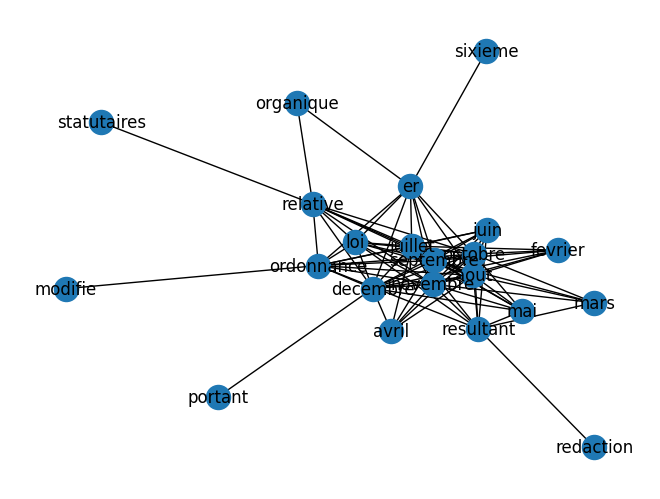

In [116]:
dessin_graphe(Gr)

In [133]:
def dessin_graphe2(G):
    # Utiliser une disposition fruchterman_reingold pour une meilleure répartition des nœuds
    pos = nx.spring_layout(G, k=0.15, iterations=50)
    
    # Dessiner les nœuds avec des paramètres pour améliorer la lisibilité
    nx.draw(G, pos, with_labels=False, node_size=30, node_color='skyblue')

     # Dessiner les arêtes avec une couleur plus claire et une transparence réduite
    nx.draw(G, pos, with_labels=False, edge_color='gray', alpha=1)
    
    # Dessiner les labels des nœuds de manière à éviter le chevauchement
    labels = nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_family='sans-serif', alpha=0.7)

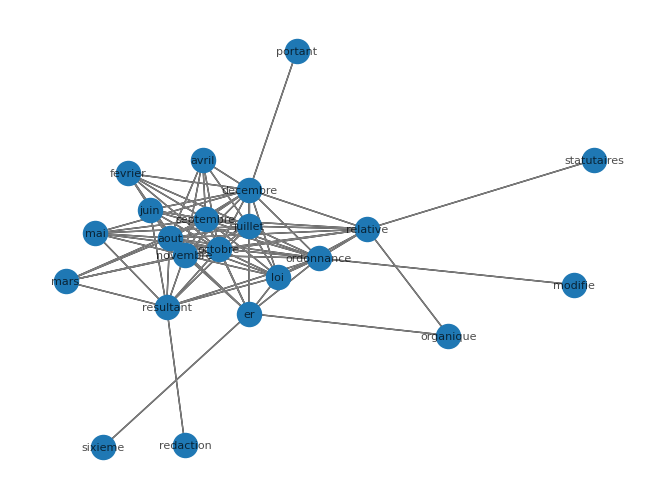

In [134]:
dessin_graphe2(Gr)

Maintenant qu'on a créé notre graphe, il faut qu'on parte à la recherche des cliques. 

Revoir pourquoi ???

In [137]:
# Trouver toutes les cliques dans le graphe
all_cliques = list(nx.find_cliques(Gr))

# Afficher les cliques
print("Cliques dans le graphe:")
for clique in all_cliques:
    print(clique)

Cliques dans le graphe:
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'mai']
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'ordonnance', 'loi']
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'ordonnance', 'juin']
['octobre', 'aout', 'novembre', 'resultant', 'mars']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'fevrier']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'avril']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'mai']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'loi', 'er']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'loi', 'relative']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'juin']
['octobre', 'aout', 'novembre', 'septembre', 'mars']
['statutaires', 'relative']
['modifie', 'ordonnance']
['organique', 'er']
['organique', 'relative']
['portant', 'decembre']
['sixieme',

On peut choisir de ne garder que les cliques maximales. \
_Rappel_ : une clique maximale est une clique qui n'est pas un sous-ensemble strict d'une autre clique. Autrement dit, si on prend une clique maximale et qu'on ajoute un nœud supplémentaire, elle ne sera plus une clique.

In [142]:
def is_clique_maximal(clique, cliques):
    for other_clique in cliques:
        if set(clique) < set(other_clique):
            return False
    return True

In [143]:
# Filtrer les cliques pour ne conserver que les cliques maximales
maximal_cliques = [clique for clique in all_cliques if is_clique_maximal(clique, all_cliques)]

# Afficher les cliques maximales
print("Cliques maximales dans le graphe:")
for clique in maximal_cliques:
    print(clique)

Cliques maximales dans le graphe:
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'mai']
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'ordonnance', 'loi']
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'ordonnance', 'juin']
['octobre', 'aout', 'novembre', 'resultant', 'mars']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'fevrier']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'avril']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'mai']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'loi', 'er']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'loi', 'relative']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'juin']
['octobre', 'aout', 'novembre', 'septembre', 'mars']
['statutaires', 'relative']
['modifie', 'ordonnance']
['organique', 'er']
['organique', 'relative']
['portant', 'decembre']
[

On cherche désormais à implémenter la distance entre deux cliques. 

La première méthode entièrement commentée fonctionne mais n'est pas optimale. 

In [203]:
# def mot_dans_clique(mot, clique):
#     if mot in clique:
#         return float(1)
#     return float(0) 

In [204]:
# mot_dans_clique('ordonnance', maximal_cliques[0])

0.0

In [225]:
# def x_point_i(mot_i, liste_cliques): 
#     #nb de cliques qui contiennent le mot_i 
#     x_point_i = 0
#     for clique in liste_cliques : 
#         x_point_i += mot_dans_clique(mot_i, clique)
#     return float(x_point_i)

# def x_k_point(clique_k, liste_mots): 
#     #nb de mots contenus dans la clique k 
#     #return float(len(clique_k))
#     x_k_point = 0
#     for mot in liste_mots : 
#         x_k_point += mot_dans_clique(mot, clique_k)
#     return float(x_k_point)

# def x(liste_mots, liste_cliques): 
#     x = 0
#     #return float(sum([len(x) for x in liste_cliques]))
#     for mot in liste_mots:
#         for clique in liste_cliques:
#             x += mot_dans_clique(mot, clique)
#     return float(x)

In [ ]:
# def distance_cliques(clique1, clique2, liste_cliques, liste_mots):
#     #on va introduire la distance chi2
#     distance = 0
#     for mot in liste_mots : 
#         coef = x(liste_mots, liste_cliques)/x_point_i(mot, liste_cliques)
#         sum = (mot_dans_clique(mot, clique1)/x_k_point(clique1, liste_mots)) - (mot_dans_clique(mot, clique2)/x_k_point(clique2, liste_mots))
#         distance += coef*(sum**2) 
#     return distance   

In [ ]:
# clique_1 = maximal_cliques[0]
# clique_2 = maximal_cliques[1]
# list_mot = list(G.nodes())
# print(clique_1, clique_2, list_mot)

In [ ]:
# distance_cliques(clique_1, clique_2, maximal_cliques, list_mot)

Méthode suivante est vectorisée : plus efficace et plus claire. 

creons $u_1$, ..., $u_n$ les synonymes Pprésents sur l'ensemble de cliques et $c_1$, $c_2$, …, $c_p$ toutes les cliques trouvées dans le graphe. 

le synonyme $u_i$ correspond au ième vecteur de base de cet espace, et la clique $c_k$ à un point dont les coordonnées $x_{ki}$
valent 0 ou 1 suivant que le synonyme correspondant appartient ou non à la clique :
$x_{ki} = 1$ si $u_i = c_k$ et $x_{ki} = 0$ si $u_i \neq c_k$

In [234]:
import numpy as np

In [235]:
synonymes = list(G.nodes())
cliques = maximal_cliques
print(synonymes)
print('')
for x in cliques :
    print(x)

['ordonnance', 'loi', 'juillet', 'resultant', 'aout', 'relative', 'octobre', 'septembre', 'novembre', 'er', 'decembre']

['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'mai']
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'ordonnance', 'loi']
['octobre', 'aout', 'novembre', 'resultant', 'juillet', 'ordonnance', 'juin']
['octobre', 'aout', 'novembre', 'resultant', 'mars']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'fevrier']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'avril']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'mai']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'loi', 'er']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'loi', 'relative']
['octobre', 'aout', 'novembre', 'septembre', 'decembre', 'juillet', 'ordonnance', 'juin']
['octobre', 'aout', 'novembre', 'septembre', 'mars']
['statutaires', 'relative']
['modifie'

In [236]:
n = len(synonymes)
p = len(cliques)
X = np.zeros((p,n))
for k in range(p) :
    for i in range(n) :
        if synonymes[i] in cliques[k] :
            X[k,i] = 1
print(X)

[[0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [229]:
def d(k,l, X = X) :
    x = np.sum(X)
    x_dot_i = np.sum(X, axis=0)
    x_k_dot = np.sum(X, axis=1)[k]
    x_l_dot = np.sum(X, axis=1)[l]
    return np.sum( (x/x_dot_i) * (X[k,:]/x_k_dot - X[l,:]/x_l_dot)**2 )



In [237]:
d(1,0)

0.9203974438260152

Maintenant qu'on a construit notre espace et introduit la notion de distance, on va pouvoir visualiser les différentes cliques. Pour ce faire, il faut pouvoir approximer notre espace par une représentation en deux dimensions. On va donc réaliser une ACP pour trouver les axes adéquats. 

Dans une ACP, les features sont toujours placés en colonne. Ici, les 'individus' sont les différentes cliques, donc il faut que les synonymes soient en colonne et les cliques en ligne. C'est déjà le cas pour la matrice X. 

In [239]:
from sklearn import decomposition

In [252]:
n = min(X.shape[0], X.shape[1])
pca = decomposition.PCA(n_components=n)
pca.fit(X)

PCA(n_components=11)

Text(0, 0.5, 'Proportion de variance expliquée')

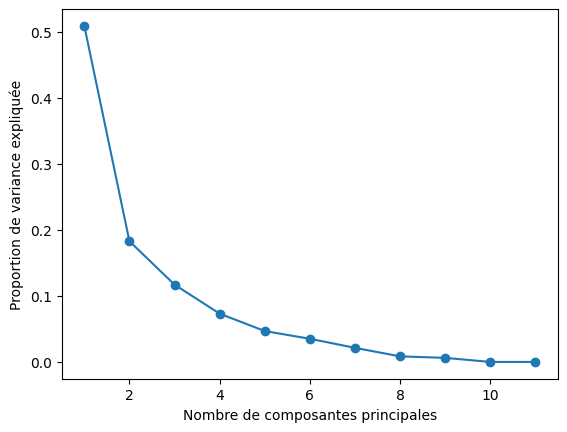

In [255]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,12), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée")

Avec 2 composantes, on explique 70% de la variance --> plutôt bon. 

In [264]:
# Appliquer l'ACP pour réduire à deux dimensions
pca = decomposition.PCA(n_components=2)
matrice_reduite = pca.fit_transform(X)


In [266]:
print(matrice_reduite  )

[[-0.41662093  1.06155719]
 [-0.77415602  1.16330801]
 [-0.61224879  1.15963957]
 [-0.00145557  1.02589834]
 [-1.0152829  -0.51984526]
 [-1.0152829  -0.51984526]
 [-1.0152829  -0.51984526]
 [-1.3024662  -0.56789908]
 [-1.3024662  -0.56789908]
 [-1.21091076 -0.42176288]
 [-0.32097684 -0.0561952 ]
 [ 1.38537235 -0.27774765]
 [ 1.11939271 -0.02986062]
 [ 1.38537235 -0.27774765]
 [ 1.38537235 -0.27774765]
 [ 1.03587986 -0.62725191]
 [ 1.38537235 -0.27774765]
 [ 1.29038806  0.53099204]]


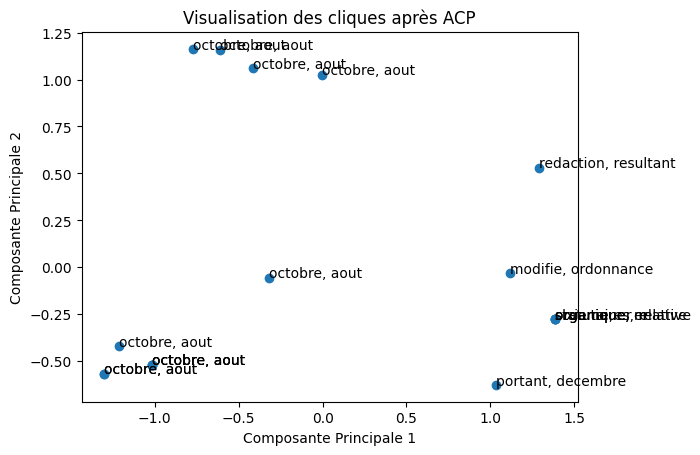

In [269]:
# Visualiser les données dans l'espace réduit
plt.scatter(matrice_reduite[:, 0], matrice_reduite[:, 1])
for (x_coordinate, y_coordinate, clique) in zip(matrice_reduite[:, 0],  matrice_reduite[:, 1], maximal_cliques):
    plt.text(x_coordinate, y_coordinate, f"{clique[0]}, {clique[1]}") 
#plt.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Visualisation des cliques après ACP')
plt.show()